In [1]:
import pandas as pd
import numpy as np
import datetime
from scipy import stats

In [2]:
pd.set_option('display.max_columns',None)
pd.options.mode.chained_assignment = None

import warnings
warnings.filterwarnings("ignore")

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn')

In [4]:
from sklearn.model_selection import KFold 
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV, LinearRegression
from sklearn.metrics import accuracy_score,classification_report,roc_curve, auc, roc_auc_score,precision_recall_curve
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.decomposition import PCA

In [5]:
#!pip install imblearn 

In [6]:
seed = 42
np.random.seed(seed)

# Import Merged Data

In [7]:
cm = pd.read_csv('cleaned_and_merged_data_v2.csv')

In [8]:
cm.head()

,LPERMNO,sic,fyear,ebitda/sale,gp/sale,ros,gross_margin,ebit/seq,ebit/at,ebitda/at,roe,roa,effective_tax_rate,fin_lev,dltt/seq,dltt/at,ch/at,at/lt,lt/at,invt/at,asset_turnover,invt_turnover,invt/sale,receivable_turnover,payable_turnover,bankrupt,bankrupt_year,CPI,GDP,inflation,unemployment,spread
0,10015,Retail Trade,1985.0,0.134708,0.748504,0.047883,0.748504,0.402490,0.132624,0.183492,0.197941,0.065223,0.454699,3.034809,0.915015,0.301507,0.042740,1.491447,0.670490,0.018711,1.362147,18.308525,0.013737,1855.103448,24.531692,0.0,1986.0,107.6,4339.0,0.0356,0.072,1.352097
1,10031,Retail Trade,1985.0,0.042871,0.427054,0.009757,0.427054,0.098725,0.047034,0.074124,0.035409,0.016869,0.387013,2.099025,0.702476,0.334668,0.000357,1.909898,0.523588,0.791351,1.729021,1.251829,0.457687,21.791892,22.130833,0.0,1989.0,107.6,4339.0,0.0356,0.072,1.352097
2,10031,Retail Trade,1986.0,0.067809,0.473422,0.021841,0.473422,0.259185,0.132524,0.168792,0.106329,0.054367,0.465993,1.955752,0.502816,0.257096,0.016523,2.046296,0.488688,0.792746,2.489236,1.653464,0.318470,47.031088,28.588976,0.0,1989.0,109.6,4579.6,0.0186,0.070,0.812360
3,10031,Retail Trade,1987.0,0.002971,0.363770,0.004979,0.363770,-0.052990,-0.025246,0.006919,0.024336,0.011595,0.421169,2.098914,0.716734,0.341479,0.029610,1.909989,0.523563,0.743174,2.328637,1.993541,0.319146,29.507109,52.392707,0.0,1989.0,113.6,4855.2,0.0365,0.062,0.977040
4,10031,Retail Trade,1988.0,-0.112168,0.337966,-0.238905,0.337966,22.536082,-0.268550,-0.226044,40.402062,-0.481450,0.088499,-83.917526,-0.536082,0.006388,0.018550,0.988224,1.011916,0.717445,2.015233,1.859589,0.356011,15.273743,10.896048,0.0,1989.0,118.3,5236.4,0.0414,0.055,0.747600


### Clean data a bit

In [9]:
cm['CPI'] = np.log10(cm['CPI'])
cm['GDP'] = np.log10(cm['GDP'])

In [24]:
cm['bankrupt'].value_counts()

0.0    174399
1.0      4634
Name: bankrupt, dtype: int64

In [23]:
cm['bankrupt'].value_counts(normalize = True)

0.0    0.974117
1.0    0.025883
Name: bankrupt, dtype: float64

# Lag one year ahead #

In [50]:
# year_lag = lag for x years 
# e.g. a row with 2018 data -- year_lag = 2 -- (2018) 2017 2016

def lag(data, year_lag = 2):

    # change the fyear to ascend within every LPERMNO
    data.sort_values(['LPERMNO', 'fyear'], ascending = [True, True], inplace = True)

    # remove irrelevant columns first
    df = data.drop(columns = ['bankrupt','bankrupt_year'])
    
    # get the columns
    columns = df.columns
    col_to_lag = columns[2:]

    # run the loops to create lag columns to the number of lagged year
    for lag in range(1, year_lag+1):
        for colname in col_to_lag:
            df[f'{colname}'+ '_lag' + f'{lag}'] = df[f'{colname}'].shift((lag-1))

    # add back the bankrupt info
    df['bankrupt'] = data['bankrupt']
    df['bankrupt_year'] = data['bankrupt_year']

    # keep the new lagged columns and remove the original one
    df.drop(col_to_lag, axis=1, inplace = True)

    # drop the first row of each LPERMNO after lagging one year
    df = df.groupby(['LPERMNO']).apply(lambda x: x.iloc[1:])
    df = df.set_index('LPERMNO').reset_index()    
    
    # identify the real bankrupt row
    for i in range(len(df)):
        if (df['bankrupt'][i] == 1) & (df['bankrupt_year'][i] - df['fyear_lag1'][i] == 1):
            df['bankrupt'][i] = 1
        else:
            df['bankrupt'][i] = 0

    df['predict_year'] = df['fyear_lag1']+1

    return df

# cmcm = lag(cm[cm['tic'] == 'TSLA'],2)
cmcm = lag(cm,2)
cmcm.head()

,LPERMNO,sic,fyear_lag1,ebitda/sale_lag1,gp/sale_lag1,ros_lag1,gross_margin_lag1,ebit/seq_lag1,ebit/at_lag1,ebitda/at_lag1,roe_lag1,roa_lag1,effective_tax_rate_lag1,fin_lev_lag1,dltt/seq_lag1,dltt/at_lag1,ch/at_lag1,at/lt_lag1,lt/at_lag1,invt/at_lag1,asset_turnover_lag1,invt_turnover_lag1,invt/sale_lag1,receivable_turnover_lag1,payable_turnover_lag1,CPI_lag1,GDP_lag1,inflation_lag1,unemployment_lag1,spread_lag1,fyear_lag2,ebitda/sale_lag2,gp/sale_lag2,ros_lag2,gross_margin_lag2,ebit/seq_lag2,ebit/at_lag2,ebitda/at_lag2,roe_lag2,roa_lag2,effective_tax_rate_lag2,fin_lev_lag2,dltt/seq_lag2,dltt/at_lag2,ch/at_lag2,at/lt_lag2,lt/at_lag2,invt/at_lag2,asset_turnover_lag2,invt_turnover_lag2,invt/sale_lag2,receivable_turnover_lag2,payable_turnover_lag2,CPI_lag2,GDP_lag2,inflation_lag2,unemployment_lag2,spread_lag2,bankrupt,bankrupt_year,predict_year
0,10001,"Transportation, Communications, Electric, Gas ...",1990.0,0.142937,0.142937,0.048693,0.142937,0.342527,0.130237,0.175838,0.157543,0.059901,0.361738,2.630032,0.999443,0.380012,0.071818,1.613485,0.619776,0.011652,1.230178,90.486364,0.009472,14.453640,20.356705,2.116276,3.775472,0.054,0.056,0.390880,1989.0,0.133304,0.133304,0.052728,0.133304,0.379845,0.129329,0.164503,0.191109,0.065069,0.368201,2.937035,1.165955,0.396984,0.063399,1.516253,0.659521,0.012335,1.234043,86.707424,0.009996,10.998560,20.185022,2.093422,3.751402,0.0482,0.053,-0.078680,0.0,2017.0,1991.0
1,10001,"Transportation, Communications, Electric, Gas ...",1991.0,0.132830,0.132830,0.044990,0.132830,0.302430,0.123170,0.161641,0.134427,0.054748,0.388952,2.455400,0.872588,0.355375,0.081382,1.687096,0.592734,0.012654,1.216899,83.395161,0.010398,12.672689,24.613003,2.134177,3.789447,0.042,0.068,1.374600,1990.0,0.142937,0.142937,0.048693,0.142937,0.342527,0.130237,0.175838,0.157543,0.059901,0.361738,2.630032,0.999443,0.380012,0.071818,1.613485,0.619776,0.011652,1.230178,90.486364,0.009472,14.453640,20.356705,2.116276,3.775472,0.0540,0.056,0.390880,0.0,2017.0,1992.0
2,10001,"Transportation, Communications, Electric, Gas ...",1992.0,0.126667,0.126667,0.036340,0.126667,0.235222,0.086242,0.130441,0.102068,0.037423,0.345882,2.727451,0.824257,0.302208,0.049358,1.578888,0.633357,0.055326,1.029794,16.255474,0.053725,14.543726,19.565217,2.147058,3.814268,0.030,0.075,2.238964,1991.0,0.132830,0.132830,0.044990,0.132830,0.302430,0.123170,0.161641,0.134427,0.054748,0.388952,2.455400,0.872588,0.355375,0.081382,1.687096,0.592734,0.012654,1.216899,83.395161,0.010398,12.672689,24.613003,2.134177,3.789447,0.0420,0.068,1.374600,0.0,2017.0,1993.0
3,10001,"Transportation, Communications, Electric, Gas ...",1993.0,0.145753,0.145753,0.046473,0.145753,0.313867,0.099913,0.146789,0.147029,0.046803,0.348884,3.141418,1.265315,0.402785,0.024969,1.466980,0.681672,0.058905,1.007108,14.605198,0.058489,10.157721,17.442551,2.159868,3.836235,0.030,0.069,1.820480,1992.0,0.126667,0.126667,0.036340,0.126667,0.235222,0.086242,0.130441,0.102068,0.037423,0.345882,2.727451,0.824257,0.302208,0.049358,1.578888,0.633357,0.055326,1.029794,16.255474,0.053725,14.543726,19.565217,2.147058,3.814268,0.0300,0.075,2.238964,0.0,2017.0,1994.0
4,10001,"Transportation, Communications, Electric, Gas ...",1994.0,0.148121,0.148121,0.048808,0.148121,0.280635,0.093825,0.145933,0.143831,0.048087,0.341871,2.991057,1.141062,0.381491,0.018224,1.502246,0.665670,0.038726,0.985229,21.672794,0.039306,10.532725,21.898734,2.170848,3.862561,0.026,0.061,1.142209,1993.0,0.145753,0.145753,0.046473,0.145753,0.313867,0.099913,0.146789,0.147029,0.046803,0.348884,3.141418,1.265315,0.402785,0.024969,1.466980,0.681672,0.058905,1.007108,14.605198,0.058489,10.157721,17.442551,2.159868,3.836235,0.0300,0.069,1.820480,0.0,2017.0,1995.0


In [51]:
cmcm['bankrupt'].value_counts()

0.0    159294
1.0       433
Name: bankrupt, dtype: int64

In [52]:
cmcm[cmcm['predict_year'] != 2020]['bankrupt'].value_counts()

0.0    158044
1.0       433
Name: bankrupt, dtype: int64

## Remove predict year = 2020 

In [53]:
cmcm = cmcm[cmcm['predict_year'] != 2020]

# Standardization by PERMNO

In [54]:
cmcm.drop(columns=['fyear_lag1','fyear_lag2', 'predict_year', 'bankrupt_year'], inplace = True)

In [89]:
def normalize_by_group(df, by):
    groups = df.groupby(by)
    # computes group-wise mean/std,
    # then auto broadcasts to size of group chunk
    mean = groups.transform(np.mean)
    std = groups.transform(np.std)
    standardize = (df[mean.columns] - mean) / std
    return standardize

cmcm_col = cmcm.drop(columns = ['LPERMNO','sic','bankrupt']).columns
cm1 = cmcm[['LPERMNO','sic','bankrupt']]

for c in cmcm_col:
    cm1[c] = normalize_by_group(cmcm[['LPERMNO', c]],'LPERMNO')

cm1.head()

,LPERMNO,sic,bankrupt,ebitda/sale_lag1,gp/sale_lag1,ros_lag1,gross_margin_lag1,ebit/seq_lag1,ebit/at_lag1,ebitda/at_lag1,roe_lag1,roa_lag1,effective_tax_rate_lag1,fin_lev_lag1,dltt/seq_lag1,dltt/at_lag1,ch/at_lag1,at/lt_lag1,lt/at_lag1,invt/at_lag1,asset_turnover_lag1,invt_turnover_lag1,invt/sale_lag1,receivable_turnover_lag1,payable_turnover_lag1,CPI_lag1,GDP_lag1,inflation_lag1,unemployment_lag1,spread_lag1,ebitda/sale_lag2,gp/sale_lag2,ros_lag2,gross_margin_lag2,ebit/seq_lag2,ebit/at_lag2,ebitda/at_lag2,roe_lag2,roa_lag2,effective_tax_rate_lag2,fin_lev_lag2,dltt/seq_lag2,dltt/at_lag2,ch/at_lag2,at/lt_lag2,lt/at_lag2,invt/at_lag2,asset_turnover_lag2,invt_turnover_lag2,invt/sale_lag2,receivable_turnover_lag2,payable_turnover_lag2,CPI_lag2,GDP_lag2,inflation_lag2,unemployment_lag2,spread_lag2
0,10001,"Transportation, Communications, Electric, Gas ...",0.0,0.721978,0.721978,0.420757,0.721978,1.354872,1.720734,1.865720,0.864427,0.870141,-0.176387,-0.359047,0.460798,1.268005,1.161293,0.017019,-0.154666,-1.430005,0.492822,3.290975,-1.642559,1.156741,0.541429,-1.795540,-1.745511,2.448910,-0.289866,-0.981535,0.431860,0.431860,0.528380,0.431860,1.653543,1.604692,1.441873,1.288929,0.998004,0.213712,0.040954,0.871260,1.371798,0.865683,-0.353622,0.256875,-1.372771,0.448228,2.568060,-1.510020,0.160393,0.465416,-1.875908,-1.739144,1.767981,-0.496554,-1.419618
1,10001,"Transportation, Communications, Electric, Gas ...",0.0,0.448449,0.448449,0.271730,0.448449,0.933249,1.499677,1.443570,0.509019,0.670461,-0.136604,-0.610712,0.097475,0.947518,1.443899,0.335623,-0.467813,-1.404074,0.456942,2.956269,-1.616023,0.669442,1.192501,-1.579206,-1.655857,1.440718,0.486304,0.156142,0.692093,0.692093,0.360913,0.692093,1.250350,1.633952,1.787612,0.767129,0.794271,0.127607,-0.412314,0.395609,1.159235,1.110729,0.079070,-0.216670,-1.390138,0.437349,2.721277,-1.524358,1.139709,0.492171,-1.609311,-1.587945,2.233146,-0.301307,-0.898105
2,10001,"Transportation, Communications, Electric, Gas ...",0.0,0.281643,0.281643,-0.076299,0.281643,0.226535,0.344626,0.515843,0.011483,-0.000788,-0.199566,-0.218656,-0.040952,0.255879,0.497589,-0.132723,0.002599,-0.299509,-0.048602,-0.212743,-0.375208,1.181390,0.420358,-1.423548,-1.496620,0.432527,0.939069,1.155783,0.419053,0.419053,0.207181,0.419053,0.817141,1.406050,1.354570,0.407792,0.591067,0.490189,-0.670146,0.033242,0.850680,1.389074,0.406648,-0.538873,-1.364669,0.399963,2.433765,-1.498999,0.634912,1.155465,-1.400485,-1.500161,1.270737,0.479680,0.194455
3,10001,"Transportation, Communications, Electric, Gas ...",0.0,0.798176,0.798176,0.331416,0.798176,1.053506,0.772214,1.001945,0.702765,0.362658,-0.195178,0.377918,1.222283,1.564254,-0.223131,-0.617077,0.562086,-0.206873,-0.109900,-0.290637,-0.238781,-0.018697,0.095661,-1.268741,-1.355686,0.432527,0.550984,0.671804,0.252545,0.252545,-0.151834,0.252545,0.091008,0.215229,0.402905,-0.095245,-0.092027,-0.083645,-0.268482,-0.104821,0.184789,0.457033,-0.074891,-0.054857,-0.279811,-0.126797,-0.288397,-0.313200,1.165244,0.368827,-1.250229,-1.344245,0.308327,0.935256,1.154453
4,10001,"Transportation, Communications, Electric, Gas ...",0.0,0.862283,0.862283,0.425363,0.862283,0.704058,0.581786,0.976515,0.653595,0.412391,-0.205429,0.161231,0.866411,1.287254,-0.422453,-0.464442,0.376780,-0.729207,-0.169016,0.042956,-0.788147,0.083911,0.777309,-1.136047,-1.186797,0.096463,0.033538,-0.112619,0.768155,0.768155,0.268751,0.768155,0.940703,0.656059,0.901550,0.603680,0.277833,-0.043648,0.342710,1.155089,1.444456,-0.252819,-0.572889,0.520810,-0.188828,-0.190667,-0.355308,-0.182823,-0.077937,0.038035,-1.100795,-1.206250,0.308327,0.544763,0.689667


In [95]:
cm1.dropna()['bankrupt'].value_counts(normalize = True)

0.0    0.997567
1.0    0.002433
Name: bankrupt, dtype: float64

In [96]:
cm1.dropna(inplace = True)

In [43]:
# col = len(cmcm.columns) - 1 # minus the y

# scaler = StandardScaler()
# x_all = pd.DataFrame(columns = list(cmcm)[2:col])
# for i in cm.LPERMNO.unique():
#     sub = cmcm[cmcm['LPERMNO']==i]
#     if len(sub)>1:
#         x1 = sub[list(sub)[2:col]]
#         x1 = pd.DataFrame(scaler.fit_transform(x1),columns=x1.columns,index=x1.index)
#         x_all = pd.concat([x_all,x1])
#     else:
#         x_all = pd.concat([x_all,sub[list(sub)[2:col]]])

# x2 = cmcm[list(cmcm)[0:2]]
# x3 = cmcm[list(cmcm)[col]]
# cm1 = pd.merge(x2, x_all, left_index = True, right_index = True)
# cm1 = pd.merge(cm1, x3, left_index = True, right_index = True)
# cm1.head()

In [97]:
dummy_sic = pd.get_dummies(cm1['sic'])
cm1.drop(columns=['LPERMNO', 'sic'], inplace = True)
cm1 = pd.concat([dummy_sic, cm1], axis=1)
cm1

,"Agriculture, Forestry and Fishing",Construction,"Finance, Insurance and Real Estate",Manufacturing,Mining,Nonclassifiable,Retail Trade,Services,"Transportation, Communications, Electric, Gas and Sanitary service",Wholesale Trade,bankrupt,ebitda/sale_lag1,gp/sale_lag1,ros_lag1,gross_margin_lag1,ebit/seq_lag1,ebit/at_lag1,ebitda/at_lag1,roe_lag1,roa_lag1,effective_tax_rate_lag1,fin_lev_lag1,dltt/seq_lag1,dltt/at_lag1,ch/at_lag1,at/lt_lag1,lt/at_lag1,invt/at_lag1,asset_turnover_lag1,invt_turnover_lag1,invt/sale_lag1,receivable_turnover_lag1,payable_turnover_lag1,CPI_lag1,GDP_lag1,inflation_lag1,unemployment_lag1,spread_lag1,ebitda/sale_lag2,gp/sale_lag2,ros_lag2,gross_margin_lag2,ebit/seq_lag2,ebit/at_lag2,ebitda/at_lag2,roe_lag2,roa_lag2,effective_tax_rate_lag2,fin_lev_lag2,dltt/seq_lag2,dltt/at_lag2,ch/at_lag2,at/lt_lag2,lt/at_lag2,invt/at_lag2,asset_turnover_lag2,invt_turnover_lag2,invt/sale_lag2,receivable_turnover_lag2,payable_turnover_lag2,CPI_lag2,GDP_lag2,inflation_lag2,unemployment_lag2,spread_lag2
0,0,0,0,0,0,0,0,0,1,0,0.0,0.721978,0.721978,0.420757,0.721978,1.354872,1.720734,1.865720,0.864427,0.870141,-0.176387,-0.359047,0.460798,1.268005,1.161293,0.017019,-0.154666,-1.430005,0.492822,3.290975,-1.642559,1.156741,0.541429,-1.795540,-1.745511,2.448910,-0.289866,-0.981535,0.431860,0.431860,0.528380,0.431860,1.653543,1.604692,1.441873,1.288929,0.998004,0.213712,0.040954,0.871260,1.371798,0.865683,-0.353622,0.256875,-1.372771,0.448228,2.568060,-1.510020,0.160393,0.465416,-1.875908,-1.739144,1.767981,-0.496554,-1.419618
1,0,0,0,0,0,0,0,0,1,0,0.0,0.448449,0.448449,0.271730,0.448449,0.933249,1.499677,1.443570,0.509019,0.670461,-0.136604,-0.610712,0.097475,0.947518,1.443899,0.335623,-0.467813,-1.404074,0.456942,2.956269,-1.616023,0.669442,1.192501,-1.579206,-1.655857,1.440718,0.486304,0.156142,0.692093,0.692093,0.360913,0.692093,1.250350,1.633952,1.787612,0.767129,0.794271,0.127607,-0.412314,0.395609,1.159235,1.110729,0.079070,-0.216670,-1.390138,0.437349,2.721277,-1.524358,1.139709,0.492171,-1.609311,-1.587945,2.233146,-0.301307,-0.898105
2,0,0,0,0,0,0,0,0,1,0,0.0,0.281643,0.281643,-0.076299,0.281643,0.226535,0.344626,0.515843,0.011483,-0.000788,-0.199566,-0.218656,-0.040952,0.255879,0.497589,-0.132723,0.002599,-0.299509,-0.048602,-0.212743,-0.375208,1.181390,0.420358,-1.423548,-1.496620,0.432527,0.939069,1.155783,0.419053,0.419053,0.207181,0.419053,0.817141,1.406050,1.354570,0.407792,0.591067,0.490189,-0.670146,0.033242,0.850680,1.389074,0.406648,-0.538873,-1.364669,0.399963,2.433765,-1.498999,0.634912,1.155465,-1.400485,-1.500161,1.270737,0.479680,0.194455
3,0,0,0,0,0,0,0,0,1,0,0.0,0.798176,0.798176,0.331416,0.798176,1.053506,0.772214,1.001945,0.702765,0.362658,-0.195178,0.377918,1.222283,1.564254,-0.223131,-0.617077,0.562086,-0.206873,-0.109900,-0.290637,-0.238781,-0.018697,0.095661,-1.268741,-1.355686,0.432527,0.550984,0.671804,0.252545,0.252545,-0.151834,0.252545,0.091008,0.215229,0.402905,-0.095245,-0.092027,-0.083645,-0.268482,-0.104821,0.184789,0.457033,-0.074891,-0.054857,-0.279811,-0.126797,-0.288397,-0.313200,1.165244,0.368827,-1.250229,-1.344245,0.308327,0.935256,1.154453
4,0,0,0,0,0,0,0,0,1,0,0.0,0.862283,0.862283,0.425363,0.862283,0.704058,0.581786,0.976515,0.653595,0.412391,-0.205429,0.161231,0.866411,1.287254,-0.422453,-0.464442,0.376780,-0.729207,-0.169016,0.042956,-0.788147,0.083911,0.777309,-1.136047,-1.186797,0.096463,0.033538,-0.112619,0.768155,0.768155,0.268751,0.768155,0.940703,0.656059,0.901550,0.603680,0.277833,-0.043648,0.342710,1.155089,1.444456,-0.252819,-0.572889,0.520810,-0.188828,-0.190667,-0.355308,-0.182823,-0.077937,0.038035,-1.100795,-1.206250,0.308327,0.544763,0.689667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
159721,0,0,0,1,0,0,0,0,0,0,0.0,0.530819,0.540652,0.565725,0.54

In [19]:
# cm1.drop(columns = 'sic', inplace = True)

# Oversampling and Undersampling

In [98]:
# Only supports Continuous Features
def oversampling(data, y_label, k = 5, seed = 1):
    
    from imblearn.over_sampling import SMOTE
    X = data.loc[:, data.columns != y_label]
    y = data[y_label]
    sm = SMOTE(sampling_strategy = 'auto', k_neighbors = k, random_state = seed)
    X_res, y_res = sm.fit_resample(X, y)
    return X_res, y_res

# Supports Categorical and Continuous Features
def oversampling_nc(data, y_label, k = 5, seed = 1, cat_features = [None]):
    
    from imblearn.over_sampling import SMOTENC
    X = data.loc[:, data.columns != y_label]
    y = data[y_label]
    sm = SMOTENC(sampling_strategy = 'auto', k_neighbors = k, random_state = seed, categorical_features = cat_features)
    X_res, y_res = sm.fit_resample(X, y)
    return X_res, y_res


def undersampling(data, y_label, n = 3):

    from imblearn.under_sampling import NearMiss
    X = data.loc[:, data.columns != y_label]
    y = data[y_label]
    nm = NearMiss(sampling_strategy = 'auto')
    X_res, y_res = nm.fit_resample(X, y)
    return X_res, y_res

In [99]:
# print(cm1['bankrupt'].value_counts())

# x, y = oversampling_nc(cm1, 'bankrupt', cat_features = list(range(0,10)))
# cm1_smote = pd.merge(x, y, left_index = True, right_index = True)
# cm1_smote['bankrupt'].value_counts()

# Cross Validation 

In [100]:
x = cm1.drop(columns = 'bankrupt')
y = cm1['bankrupt']

In [101]:
x_train, x_test, y_train, y_test = train_test_split(x, y, train_size = 0.75, random_state = 1)

print(y_train.value_counts(normalize = True))
print(y_test.value_counts(normalize = True))

0.0    0.997521
1.0    0.002479
Name: bankrupt, dtype: float64
0.0    0.997702
1.0    0.002298
Name: bankrupt, dtype: float64


In [102]:
# Split data using stratified method is better for imbalance data

x_train, x_test, y_train, y_test = train_test_split(x, y, train_size = 0.75, random_state = 1, stratify = y)

print(y_train.value_counts(normalize = True))
print(y_train.value_counts())

print(y_test.value_counts(normalize = True))
print(y_test.value_counts())

0.0    0.997564
1.0    0.002436
Name: bankrupt, dtype: float64
0.0    115914
1.0       283
Name: bankrupt, dtype: int64
0.0    0.997573
1.0    0.002427
Name: bankrupt, dtype: float64
0.0    38639
1.0       94
Name: bankrupt, dtype: int64


In [103]:
# y_train.reset_index(drop = True, inplace = True)
# y_test.reset_index(drop = True, inplace = True)

In [104]:
# #PCA

# from sklearn.decomposition import PCA

# pca = PCA(n_components = 5)
# x_train = pca.fit_transform(x_train)
# x_test = pca.transform(x_test)

# x_train = pd.DataFrame(data = x_train, columns = ['PC1', 'PC2', 'PC3', 'PC4', 'PC5'])
# x_test = pd.DataFrame(data = x_test, columns = ['PC1', 'PC2', 'PC3', 'PC4', 'PC5'])

In [105]:
# plt.bar(np.arange(1,len(pca.explained_variance_ratio_)+1), pca.explained_variance_ratio_)

# sum(pca.explained_variance_ratio_)

## Oversampling after doing Stratified Split

In [107]:
cm_test = pd.merge(x_train, y_train, left_index = True, right_index = True)

x_train, y_train = oversampling_nc(cm_test, 'bankrupt', cat_features = list(range(0,10)))
# x_train, y_train = oversampling(cm_test, 'bankrupt')
cm1_smote = pd.merge(x_train, y_train, left_index = True, right_index = True)

cm1_smote['bankrupt'].value_counts()

1.0    115914
0.0    115914
Name: bankrupt, dtype: int64

In [108]:
model = LogisticRegression()
performance_acc = cross_val_score(model, x_train, y_train, cv = 5, scoring = 'accuracy')
performance_f1 = cross_val_score(model, x_train, y_train, cv = 5, scoring = 'f1')

print(performance_acc)
print(performance_f1)

[0.94959669 0.95067506 0.95175344 0.95162299 0.9512132 ]
[0.94993895 0.95105194 0.95207079 0.95191339 0.95157561]


## Logistic Lasso

In [34]:
# lasso = LogisticRegressionCV(Cs = 20, penalty = 'l1', solver = 'liblinear', n_jobs = -1, verbose = 1)
# lasso.fit(x_train, y_train)

In [35]:
# lasso.C_

In [36]:
# list(zip(x_train.columns,lasso.coef_[0]))

## Base Model

In [109]:
from sklearn.model_selection import KFold 
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV, LinearRegression, Lasso
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score,classification_report,roc_curve, auc, roc_auc_score, precision_recall_curve
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.model_selection import GridSearchCV, cross_val_score

In [110]:
lr = LogisticRegression()
# rf = RandomForestClassifier()

lr.fit(x_train, y_train)
# rf.fit(x_train, y_train)

y_pred = lr.predict_proba(x_test)
# y_pred = rf.predict_proba(x_test)

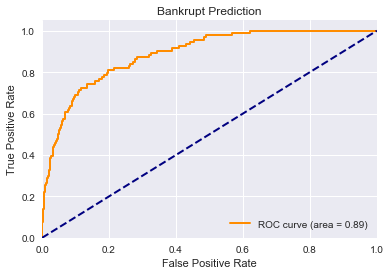

In [111]:
fpr,tpr,threshold = roc_curve(y_test, y_pred[:,1])
roc_auc = auc(fpr,tpr)
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Bankrupt Prediction')
plt.legend(loc="lower right")
plt.show()

Best F1 is 0.12371134020618556 at threshold = [0.98838276]


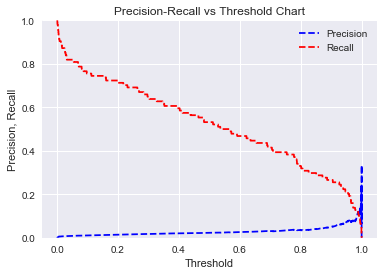

In [112]:
precision, recall, thresholds = precision_recall_curve(y_test, y_pred[:,1])
pr_auc = auc(recall, precision)
plt.title("Precision-Recall vs Threshold Chart") 
plt.plot(thresholds, precision[: -1], "b--", label="Precision") 
plt.plot(thresholds, recall[: -1], "r--", label="Recall") 
plt.ylabel("Precision, Recall")
plt.xlabel("Threshold")
plt.legend(loc="best")
plt.ylim([0,1])

f1 = 2*(precision*recall)/(precision+recall)

best_f1 = max(f1)
best_threshold = thresholds[np.where(f1 == max(f1))]
print(f'Best F1 is {best_f1} at threshold = {best_threshold}')

In [113]:
y_pred_binary = [1 if i >= best_threshold else 0 for i in y_pred[:,1]]

print(classification_report(y_test, y_pred_binary, digits=5))

precision    recall  f1-score   support

         0.0    0.99788   0.99772   0.99780     38639
         1.0    0.12000   0.12766   0.12371        94

    accuracy                        0.99561     38733
   macro avg    0.55894   0.56269   0.56076     38733
weighted avg    0.99575   0.99561   0.99568     38733



# Exploratory Data Analysis #

In [42]:
#! pip install pandas-profiling

In [43]:
# import pandas_profiling
# profile = pandas_profiling.ProfileReport(cm1)
# profile.to_file(outputfile = 'Profile.html')
# profile

In [44]:
cmcm.head()

NameError: name 'cmcm' is not defined

In [5]:
bankrupt = cmcm[cmcm['bankrupt']==1]
not_bankrupt = cmcm[cmcm['bankrupt']==0]

NameError: name 'cmcm' is not defined

In [6]:
# for i in list(cmcm)[2:66]:
#     plt.figure(figsize=(8,5), dpi= 80)
#     sns.kdeplot(bankrupt[i], shade=True, color="pink", label="Bankrupt", alpha=.7)
#     sns.kdeplot(not_bankrupt[i], shade=True, color="orange", label="Not Bankrupt", alpha=.7)
# #     sns.kdeplot(DT_df['price'], shade=True, color="lightgreen", label="DT", alpha=.7)
#     plt.title('Density Plot of'+ f'{i}'+ 'by Bankrupt or not', fontsize=10)
#     plt.legend()